In [1]:
import sys
import os
import numpy as np
import dadi
from dadi import Numerics, PhiManip, Integration, Misc
from dadi.Spectrum_mod import Spectrum
import pylab
import matplotlib.pyplot as plt
import argparse
import pandas

## Build a dictionary of the best model and its parameters

Choose the population pair to investigate:

In [17]:
pops = "sm_ki"
pop_ids = pops.split("_")

In [3]:
pops = "lpa-wel"
pop_ids = pops.split("-")

In [18]:
pop_ids

['sm', 'ki']

Import all of the optimization results:

In [19]:
opti_result_dir = "/Users/enrico/Documents/Lynx-Introgression-Scans/2-infer_demographic_history/dadi/tables/"

all_best_lls = []

for chosen_model in ["model_1_a", "model_1_b", "model_2_a", "model_2_b", "model_2_c"]:
    
    for i in range(1, 21):
    
        model_file_name = [opti_result_dir, pops, ".", chosen_model, ".optimized.r_", str(i), ".txt"]
        model_file_name = ''.join(model_file_name)
        if os.path.isfile(model_file_name):
            model_optimized_allrounds = pandas.read_csv(model_file_name, sep='\t')
            ll_col = model_optimized_allrounds.loc[:,"log-likelihood"]
            best_ll = model_optimized_allrounds.iloc[ll_col.idxmax(),]
            all_best_lls.append(best_ll)

**RUN THIS ONLY FOR TESTING WITH RESULTS FROM model_2_d :**

In [20]:
opti_result_dir = "/Users/enrico/Documents/Lynx-Introgression-Scans/2-infer_demographic_history/dadi/tables/"

all_best_lls = []

for chosen_model in ["model_2_d"]:
    
    for i in range(1, 21):
    
        model_file_name = [opti_result_dir, pops, ".", chosen_model, ".optimized.r_", str(i), ".txt"]
        model_file_name = ''.join(model_file_name)
        if os.path.isfile(model_file_name):
            model_optimized_allrounds = pandas.read_csv(model_file_name, sep='\t')
            ll_col = model_optimized_allrounds.loc[:,"log-likelihood"]
            best_ll = model_optimized_allrounds.iloc[ll_col.idxmax(),]
            all_best_lls.append(best_ll)

Extract best scoring model and its parameters:

In [21]:
all_best_lls_df = pandas.concat(all_best_lls, axis=1).T
best_ll = all_best_lls_df.sort_values('log-likelihood', ascending=False)[:1]
if best_ll.iloc[0,0] == "model_1_a":
    param_string = best_ll.iloc[0,6].split(",")
if best_ll.iloc[0,0] == "model_1_b":
    param_string = best_ll.iloc[0,6].split(",")
if best_ll.iloc[0,0] == "model_2_a":
    param_string = best_ll.iloc[0,6].split(",")
if best_ll.iloc[0,0] == "model_2_b":
    param_string = best_ll.iloc[0,6].split(",")
if best_ll.iloc[0,0] == "model_2_c":
    param_string = best_ll.iloc[0,6].split(",")
if best_ll.iloc[0,0] == "model_2_d":
    param_string = best_ll.iloc[0,6].split(",")
params = [float(l) for l in param_string]

Build parameter dictionary:

In [22]:
if len(params) == 9:
    param_def = ["Tsplit", "Tbot", "iber_a", "iber_pr", "eura_a", "eura_pr"]
if len(params) == 13:
    param_def = ["Tsplit", "Tbot", "Tbot_a", "iber_a", "iber_pr_a", "iber_pr", "eura_a", "eura_pr"]
par_dict = {param_def[i]: params[i] for i in range(len(param_def))}
par_dict['theta'] = best_ll.iloc[0,5]
par_dict['pop2'] = pop_ids[1]
par_dict['best_model'] = best_ll.iloc[0,0]
par_dict

{'Tsplit': 0.9658,
 'Tbot': 0.2603,
 'Tbot_a': 0.5368,
 'iber_a': 0.4244,
 'iber_pr_a': 0.1247,
 'iber_pr': 0.5396,
 'eura_a': 0.0248,
 'eura_pr': 0.1814,
 'theta': 19462667.95,
 'pop2': 'ki',
 'best_model': 'model_2_d'}

## Try with one function for model_2_d only:

To try out the ms function you will only need two things:
 - the input parameters
 - the two functions to draw values from uniform distributions

The parameters can be imported like this:

In [2]:
#  ["Tsplit", "Tbot", "Tbot_a", "iber_a", "iber_pr_a", "iber_pr", "eura_a", "eura_pr", "theta", "pop2"]
params = [0.1896, 0.0618,4.58, 0.8253, 0.3536, 0.1042, 0.1001, 0.9898, 1508523.35, 'wel']
# params = [0.738, 0.5249, 0.1597, 0.1952, 0.9899, 0.7163, 0.3018, 0.3928, 4424076.34, 'wel']
# params = [2.8224, 0.1495, 0.6146, 0.1966, 0.99,0.99, 0.187, 0.1809, 892202.65, 'wel']

They come from an optimization round made for the model, but are not expected to be really optimal. They are given in the order required by the ms functiom and you can find their description there.

The two functions for drawing values are these:

In [3]:
def draw_uni(param):
    """
    function to draw a random number from a uniform distribution between 0.5 and 1.5 times the value
    """
    low_bound = param * 0.5
    up_bound = param * 1.5
    draw = np.random.uniform(low=low_bound, high=up_bound)
    return draw

#############################################

def draw_uni_cap(param):
    """
    function to draw a random number from a uniform distribution between 0.5 and 1.5 times the value

    including an upper limit to the drawn value of 1:

    if a values > 1 are present in the uniform distribution, values between the value and 1 will be as likely
    to be drawn as values between 0.5 times the value and the value

    sorry you had to read that
    """
    low_bound = param * 0.5
    up_bound = param * 1.5
    draw = np.random.uniform(low=low_bound, high=up_bound)
    if draw > 1:
        draw = np.random.uniform(low=param, high=1)
    return draw

check if draw_uni_cap is doing what it's supposed to:

(array([  5.,  12.,  14.,  12.,  12.,   7.,  11.,   7.,  11.,   8.,  13.,
         13.,   8.,   7.,   9.,   9.,   6.,  12.,  11.,  10.,   8.,  15.,
         17.,  10.,   7.,  10.,   8.,  13.,  13.,   7.,  10.,  10.,   8.,
          9.,  13.,   7.,  10.,   7.,  10.,  14.,  18.,   9.,   7.,  11.,
          8.,   8.,  12.,   5.,   8., 505.]),
 array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
        0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
        0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
        0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
        0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 <BarContainer object of 50 artists>)

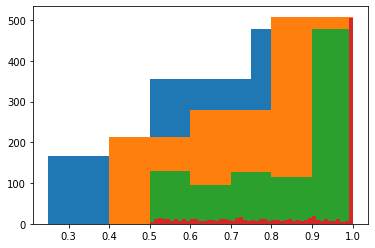

In [5]:
k = [draw_uni_cap(0.75) for x in range(1000)]
plt.hist(k, bins=np.arange(0.25, 1.0001, 0.25))

z = [draw_uni_cap(0.8) for x in range(1000)]
plt.hist(z, bins=np.arange(0.4, 1.0001, 0.2))

y = [draw_uni_cap(0.9) for x in range(1000)]
plt.hist(y, bins=np.arange(0.5, 1.0001, 0.1))

x = [draw_uni_cap(0.99) for x in range(1000)]
plt.hist(x, bins=np.arange(0.5, 1.0001, 0.01))

Here is the function with migration from pop 2 to pop 1:

In [6]:
def model_2_d_ms_m21(params):
    """
    Use input parameters from dadi to build an MS command corresponding to model_2_d
    with one migration from pop2 into pop1
    
    model_2_d consists of population divergence followed by:
     - two consecutive exponential bottlenecks in iberian lynx
     - one exponential bottleneck in eurasian lynx

    """
    
    Tsplit, Tbot2, Tbot1, iber_a, iber_pr_a, iber_pr, eura_a, eura_pr, theta, pop2 = params
    
    """
    the input parameters are defined as follows from the dadi function:
    
    Tsplit = time span between divergence and first bottleneck event
    
    Tbot1 = time span between first and second bottleneck events
           
    Tbot2 = time span between second bottleneck event and present
    
    iber_a = population size of iberian lynx at time of divergence (ancient)
    
    iber_pr_a = proportion of iberian lynx population left after first bottleneck
                size after first bottleneck = iber_a * iber_pr_a
                between 0 and 1

    iber_pr = proportion of iberian lynx population left after second bottleneck
                size after second bottleneck = iber_a * iber_pr_a * iber_pr
                between 0 and 1
    
    eura_a = population size of eurasian lynx at time of divergence (ancient)
    
    eura_pr = proportion of eurasian lynx population after bottleneck
                size after bottleneck = eura_a * eura_pr
                between 0 and 1
    
    theta = optimal multiplicative scaling factor between model and data (dadi.Inference.optimal_sfs_scaling)
            value for whole "callable" genome
    
    pop2 = name of the eurasian lynx population
    """
    
    # draw parameter values from uniform distribution around optimized value:
    Tsplit = draw_uni(Tsplit)
    Tbot1 = draw_uni(Tbot1)
    Tbot2 = draw_uni(Tbot2)
    iber_a = draw_uni(iber_a)
    iber_pr_a = draw_uni_cap(iber_pr_a)
    iber_pr = draw_uni_cap(iber_pr)
    eura_a = draw_uni(eura_a)
    eura_pr = draw_uni_cap(eura_pr)
    theta = draw_uni(theta)
    if pop2 == "ki" or "wel":
        n_pop2 = 40
    if pop2 == "eel":
        n_pop2 = 38
    if pop2 == "sel":
        n_pop2 = 24
    
    """
    input values are expected to be optimized
    
    the function draw_uni will draw a value from a uniform distribution that goes 
    from 0.5 * value to 1.5 * value
    
    the function draw_uni_cap will do the same but it is applied to values that go
    from 0 to 1 so that values above the value are equally as likely to be drawn as
    values below the value
    
    sample size of the eurasian lynx (population 2) is variable and depends on what population is chosen
    sample size of iberian lynx is always the same so we don't need to define it
    """
    
    # theta rescaling to 100KB/EffectiveGenomeLength - see (1-prepare_dataset.md)
    if pop2 == "wel":
        rescale_factor = 100000/612311182
    if pop2 == "eel":
        rescale_factor = 100000/612178519
    if pop2 == "sel":
        rescale_factor = 100000/612085036

    theta = theta * rescale_factor
    
    # intermediate population:
    iber_i = iber_a*iber_pr_a
    # contemporary populations:
    iber_c = iber_a*iber_pr_a*iber_pr
    eura_c = eura_a*eura_pr
    
    # growth rate in iberian:
    iber_alpha_2 = np.log(iber_c/iber_i)/Tbot2
    iber_alpha_1 = np.log(iber_i/iber_a)/Tbot1
    
    # growth rate in eurasian:
    eura_alpha = np.log(eura_c/eura_a)/Tbot1
 
    # recombination rho:
    rho = theta * (0.019 / 0.006)
    nsites = 10000
   
    # transform dadi units to ms units:
    Tsum = (Tbot2+Tbot1+Tsplit)/2
    Tb1 = (Tbot2+Tbot1)/2
    Tb2 = Tbot2/2
    eura_alpha = 2 * eura_alpha
    iber_alpha_1 = 2 * iber_alpha_1
    iber_alpha_2 = 2 * iber_alpha_2

    # migration parameters
    Tm = np.random.uniform(0, 0.25 * Tsum)
    Mprob =  np.random.uniform(0,1)
   
    """
    the parameter values need to be transformed and rescaled in order to be used by MS:
    
    theta = rescaled from effective genome size to the size of the window to be simulated
    
    proportional times and sizes are calculated from original values:
        iber_i = size after first bottleneck (intermediate) = iber_a * iber_pr_a
        iber_c = size after second bottleneck (contemporary) = iber_a*iber_pr_a*iber_pr
        eura_c = size after bottleneck (contemporary) = eura_a * eura_pr
        
    growth rates are calculated as the log of the ratio between starting size and ending size (going back in time)
        divided by the time length of the bottleneck event

    rho is calculated from theta considering a recombination rate of 1.9 cM/Mbp and
        a mutation rate of 6*10e-9 per site per generation
    
    nsite is set to 10000 to have significantly more recombination events than segregating sites in the
        simulated data (~200 expected)
    
    units are transformed from dadi to ms scales by dividing times by a factor of 2
    
    time in MS is also the sum of individual time frames calculated by dadi, going from present to the past
    
    migration parameters are also generated by drawing the time of migration from a uniform distribution 
        between 0 and 0.25 * time of divergence, 
        and the probability of migration from a uniform distribution between 0 and 1
    """
    
    # command if time of migration is < than time of second bottleneck:
    if Tm < Tb2:
        command = "-t %(theta)f -I 2 38 %(n_pop2)i "\
                  "-n 1 %(iber_c)f -n 2 %(eura_c)f "\
                  "-eg 0 1 %(iber_alpha_2)f "\
                  "-eg 0 2 %(eura_alpha)f "\
                  "-ev %(Tm)f 2 1 %(Mprob)f "\
                  "-en %(Tb2)f 1 %(iber_i)f "\
                  "-eg %(Tb2)f 1 %(iber_alpha_1)f "\
                  "-en %(Tb1)f 1 %(iber_a)f "\
                  "-en %(Tb1)f 2 %(eura_a)f "\
                  "-ej %(Tsum)f 2 1 "\
                  "-r %(rho)f %(nsites)i"
                  
    # command if time of second bottleneck is <= than time of migration < time of first bottleneck
    if Tb2 <= Tm and Tm < Tb1:
        command = "-t %(theta)f -I 2 38 %(n_pop2)i "\
                  "-n 1 %(iber_c)f -n 2 %(eura_c)f "\
                  "-eg 0 1 %(iber_alpha_2)f "\
                  "-eg 0 2 %(eura_alpha)f "\
                  "-en %(Tb2)f 1 %(iber_i)f "\
                  "-eg %(Tb2)f 1 %(iber_alpha_1)f "\
                  "-ev %(Tm)f 2 1 %(Mprob)f "\
                  "-en %(Tb1)f 1 %(iber_a)f "\
                  "-en %(Tb1)f 2 %(eura_a)f "\
                  "-ej %(Tsum)f 2 1 "\
                  "-r %(rho)f %(nsites)i"

    # command if time of first bottleneck is <= than time of migration
    if Tb1 <= Tm:
        command = "-t %(theta)f -I 2 38 %(n_pop2)i "\
                  "-n 1 %(iber_c)f -n 2 %(eura_c)f "\
                  "-eg 0 1 %(iber_alpha_2)f "\
                  "-eg 0 2 %(eura_alpha)f "\
                  "-en %(Tb2)f 1 %(iber_i)f "\
                  "-eg %(Tb2)f 1 %(iber_alpha_1)f "\
                  "-en %(Tb1)f 1 %(iber_a)f "\
                  "-en %(Tb1)f 2 %(eura_a)f "\
                  "-ev %(Tm)f 2 1 %(Mprob)f "\
                  "-ej %(Tsum)f 2 1 "\
                  "-r %(rho)f %(nsites)i"

    """
    The actual MS command!
    
    Timeline going from present to past:
    
    (0) the migration event at time Tm is positioned always before Tsum (by definition)
        and can fall anywhere relatively to the two bottleneck events, hence the if statements

    (1) iberian is population 1 and eurasian is population 2
    
    (2) the two populations have sizes iber_c and eura_c (iberian and eurasian contemporary)
    
    (3) iberian lynx experiences exponential change:
            from population sizes iber_c to iber_i (iberian intermediate)
            from time 0 to time Tb2 (time of second bottleneck)
            calculated as iber_alpha_2 (growth factor)
    
    (4) eurasian lynx experiences exponential change:
            from population sizes eura_c to eura_a (eurasian ancient)
            from time 0 to time Tb1 (time of first bottleneck)
            calculated as eura_alpha (growth factor)

    (5) iberian population size is set to iber_i at time Tb2 to stop exponential change
    
    (6) iberian lynx experiences another exponential change:
            from population sizes iber_i to iber_a (iberian ancient)
            from time Tb2 to time Tb1 (time of first bottleneck)
            calculated as iber_alpha_1 (growth factor)
    
    (7) iberian and eurasian population sizes are set to iber_a and eura_a
        at time TB1 to stop exponential change
    
    (8) all the individuals from one population are moved into the other at
        time Tsum (divergence event backwards)
    
    """

    # substitute values in command:
    sub_dict = {'theta':theta, 'n_pop2':n_pop2,
                'iber_c':iber_c, 'eura_c':eura_c,
                'Tm':Tm, 'Mprob':Mprob,
                'iber_alpha_2':iber_alpha_2,
                'iber_alpha_1':iber_alpha_1,
                'eura_alpha':eura_alpha,
                'iber_i':iber_i, 'iber_a':iber_a, 'eura_a':eura_a,
                'Tb2':Tb2, 'Tb1':Tb1, 'Tsum':Tsum,
                'rho':rho, 'nsites':nsites}
    
    return command % sub_dict

Here is the function with migration from pop 2 to pop 1:

Here is the function with no migration:

Run the function one time to see if it works:

In [7]:
model_2_d_ms_m21(params)

'-t 299.733904 -I 2 38 40 -n 1 0.035198 -n 2 0.085613 -eg 0 1 -52.994710 -eg 0 2 -0.005245 -en 0.043798 1 0.358554 -eg 0.043798 1 -0.716007 -ev 0.053430 2 1 0.133151 -en 1.691459 1 1.166562 -en 1.691459 2 0.086357 -ej 1.742492 2 1 -r 949.157363 10000'

### build input file for -f filename

In [8]:
commands = [model_2_d_ms_m21(params) for x in range(300)]

In [9]:
print('\n'.join(map(str, commands)))

-t 197.866892 -I 2 38 40 -n 1 0.031942 -n 2 0.121421 -eg 0 1 -135.516897 -eg 0 2 -0.004337 -en 0.015746 1 0.269842 -eg 0.015746 1 -0.402684 -ev 0.506796 2 1 0.574438 -en 1.952094 1 0.588498 -en 1.952094 2 0.122445 -ej 2.028954 2 1 -r 626.578492 10000
-t 281.757251 -I 2 38 40 -n 1 0.019296 -n 2 0.136884 -eg 0 1 -96.018723 -eg 0 2 -0.006156 -en 0.026734 1 0.251368 -eg 0.026734 1 -1.116925 -ev 0.181527 2 1 0.317180 -en 1.274587 1 1.013005 -en 1.274587 2 0.137940 -ej 1.351924 2 1 -r 892.231295 10000
-t 158.282528 -I 2 38 40 -n 1 0.020606 -n 2 0.067901 -eg 0 1 -106.740636 -eg 0 2 -0.000294 -en 0.023625 1 0.256546 -eg 0.023625 1 -0.396346 -ev 0.185228 2 1 0.515817 -en 2.197411 1 0.607213 -en 2.197411 2 0.067945 -ej 2.320849 2 1 -r 501.228007 10000
-t 328.032694 -I 2 38 40 -n 1 0.044388 -n 2 0.101764 -eg 0 1 -54.635848 -eg 0 2 -0.001423 -en 0.038244 1 0.358689 -eg 0.038244 1 -0.423376 -ev 0.079477 2 1 0.077263 -en 2.765976 1 1.138325 -en 2.765976 2 0.102159 -ej 2.905234 2 1 -r 1038.770197 100

### build input file for tbs < inputfile

the ms function needs to be modified because we want parameters always in the same order:

In [10]:
def model_2_d_ms_m21(params):
    """
    Use input parameters from dadi to build an MS command corresponding to model_2_d
    with one migration from pop2 into pop1
    
    model_2_d consists of population divergence followed by:
     - two consecutive exponential bottlenecks in iberian lynx
     - one exponential bottleneck in eurasian lynx

    """
    
    Tsplit, Tbot2, Tbot1, iber_a, iber_pr_a, iber_pr, eura_a, eura_pr, theta, pop2 = params
    
    """
    the input parameters are defined as follows from the dadi function:
    
    Tsplit = time span between divergence and first bottleneck event
    
    Tbot1 = time span between first and second bottleneck events
           
    Tbot2 = time span between second bottleneck event and present
    
    iber_a = population size of iberian lynx at time of divergence (ancient)
    
    iber_pr_a = proportion of iberian lynx population left after first bottleneck
                size after first bottleneck = iber_a * iber_pr_a
                between 0 and 1

    iber_pr = proportion of iberian lynx population left after second bottleneck
                size after second bottleneck = iber_a * iber_pr_a * iber_pr
                between 0 and 1
    
    eura_a = population size of eurasian lynx at time of divergence (ancient)
    
    eura_pr = proportion of eurasian lynx population after bottleneck
                size after bottleneck = eura_a * eura_pr
                between 0 and 1
    
    theta = optimal multiplicative scaling factor between model and data (dadi.Inference.optimal_sfs_scaling)
            value for whole "callable" genome
    
    pop2 = name of the eurasian lynx population
    """
    
    # draw parameter values from uniform distribution around optimized value:
    Tsplit = draw_uni(Tsplit)
    Tbot1 = draw_uni(Tbot1)
    Tbot2 = draw_uni(Tbot2)
    iber_a = draw_uni(iber_a)
    iber_pr_a = draw_uni_cap(iber_pr_a)
    iber_pr = draw_uni_cap(iber_pr)
    eura_a = draw_uni(eura_a)
    eura_pr = draw_uni_cap(eura_pr)
    theta = draw_uni(theta)
    if pop2 == "ki" or "wel":
        n_pop2 = 40
    if pop2 == "eel":
        n_pop2 = 38
    if pop2 == "sel":
        n_pop2 = 24
    
    """
    input values are expected to be optimized
    
    the function draw_uni will draw a value from a uniform distribution that goes 
    from 0.5 * value to 1.5 * value
    
    the function draw_uni_cap will do the same but it is applied to values that go
    from 0 to 1 so that values above the value are equally as likely to be drawn as
    values below the value
    
    sample size of the eurasian lynx (population 2) is variable and depends on what population is chosen
    sample size of iberian lynx is always the same so we don't need to define it
    """
    
    # theta rescaling to 100KB/EffectiveGenomeLength - see (1-prepare_dataset.md)
    if pop2 == "wel":
        rescale_factor = 100000/612311182
    if pop2 == "eel":
        rescale_factor = 100000/612178519
    if pop2 == "sel":
        rescale_factor = 100000/612085036

    theta = theta * rescale_factor
    
    # intermediate population:
    iber_i = iber_a*iber_pr_a
    # contemporary populations:
    iber_c = iber_a*iber_pr_a*iber_pr
    eura_c = eura_a*eura_pr
    
    # growth rate in iberian:
    iber_alpha_2 = np.log(iber_c/iber_i)/Tbot2
    iber_alpha_1 = np.log(iber_i/iber_a)/Tbot1
    
    # growth rate in eurasian:
    eura_alpha = np.log(eura_c/eura_a)/Tbot1
 
    # recombination rho:
    rho = theta * (0.019 / 0.006)
    nsites = 10000
   
    # transform dadi units to ms units:
    Tsum = (Tbot2+Tbot1+Tsplit)/2
    Tb1 = (Tbot2+Tbot1)/2
    Tb2 = Tbot2/2
    eura_alpha = 2 * eura_alpha
    iber_alpha_1 = 2 * iber_alpha_1
    iber_alpha_2 = 2 * iber_alpha_2

    # migration parameters
    Tm = np.random.uniform(0, 0.25 * Tsum)
    Mprob =  np.random.uniform(0,1)
   
    """
    the parameter values need to be transformed and rescaled in order to be used by MS:
    
    theta = rescaled from effective genome size to the size of the window to be simulated
    
    proportional times and sizes are calculated from original values:
        iber_i = size after first bottleneck (intermediate) = iber_a * iber_pr_a
        iber_c = size after second bottleneck (contemporary) = iber_a*iber_pr_a*iber_pr
        eura_c = size after bottleneck (contemporary) = eura_a * eura_pr
        
    growth rates are calculated as the log of the ratio between starting size and ending size (going back in time)
        divided by the time length of the bottleneck event

    rho is calculated from theta considering a recombination rate of 1.9 cM/Mbp and
        a mutation rate of 6*10e-9 per site per generation
    
    nsite is set to 10000 to have significantly more recombination events than segregating sites in the
        simulated data (~200 expected)
    
    units are transformed from dadi to ms scales by dividing times by a factor of 2
    
    time in MS is also the sum of individual time frames calculated by dadi, going from present to the past
    
    migration parameters are also generated by drawing the time of migration from a uniform distribution 
        between 0 and 0.25 * time of divergence, 
        and the probability of migration from a uniform distribution between 0 and 1
    """
    
    # command
    command = "-t %(theta)f -I 2 38 %(n_pop2)i "\
              "-n 1 %(iber_c)f -n 2 %(eura_c)f "\
              "-eg 0 1 %(iber_alpha_2)f "\
              "-eg 0 2 %(eura_alpha)f "\
              "-ev %(Tm)f 2 1 %(Mprob)f "\
              "-en %(Tb2)f 1 %(iber_i)f "\
              "-eg %(Tb2)f 1 %(iber_alpha_1)f "\
              "-en %(Tb1)f 1 %(iber_a)f "\
              "-en %(Tb1)f 2 %(eura_a)f "\
              "-ej %(Tsum)f 2 1 "\
              "-r %(rho)f %(nsites)i"
                  
    """
    The actual MS command!
    
    Timeline going from present to past:
    
    (0) the migration event at time Tm is positioned always before Tsum (by definition)
        and can fall anywhere relatively to the two bottleneck events, hence the if statements

    (1) iberian is population 1 and eurasian is population 2
    
    (2) the two populations have sizes iber_c and eura_c (iberian and eurasian contemporary)
    
    (3) iberian lynx experiences exponential change:
            from population sizes iber_c to iber_i (iberian intermediate)
            from time 0 to time Tb2 (time of second bottleneck)
            calculated as iber_alpha_2 (growth factor)
    
    (4) eurasian lynx experiences exponential change:
            from population sizes eura_c to eura_a (eurasian ancient)
            from time 0 to time Tb1 (time of first bottleneck)
            calculated as eura_alpha (growth factor)

    (5) iberian population size is set to iber_i at time Tb2 to stop exponential change
    
    (6) iberian lynx experiences another exponential change:
            from population sizes iber_i to iber_a (iberian ancient)
            from time Tb2 to time Tb1 (time of first bottleneck)
            calculated as iber_alpha_1 (growth factor)
    
    (7) iberian and eurasian population sizes are set to iber_a and eura_a
        at time TB1 to stop exponential change
    
    (8) all the individuals from one population are moved into the other at
        time Tsum (divergence event backwards)
    
    """

    # substitute values in command:
    sub_dict = {'theta':theta, 'n_pop2':n_pop2,
                'iber_c':iber_c, 'eura_c':eura_c,
                'Tm':Tm, 'Mprob':Mprob,
                'iber_alpha_2':iber_alpha_2,
                'iber_alpha_1':iber_alpha_1,
                'eura_alpha':eura_alpha,
                'iber_i':iber_i, 'iber_a':iber_a, 'eura_a':eura_a,
                'Tb2':Tb2, 'Tb1':Tb1, 'Tsum':Tsum,
                'rho':rho, 'nsites':nsites}
    
    return command % sub_dict

In [11]:
command = model_2_d_ms_m21(params).split(" ")

In [12]:
indeces = [command.index(p) for p in command if "." in p]
indeces

[1, 8, 11, 15, 19, 21, 24, 26, 28, 26, 32, 34, 36, 34, 40, 42, 46]

In [13]:
tbs_line = [command[index] for index in indeces]
tbs_line = print(' '.join(map(str, tbs_line)))

338.875165 0.020938 0.092779 -66.871299 -0.001959 0.136455 0.884549 0.039079 0.285666 0.039079 -0.666190 1.353832 0.685879 1.353832 0.093019 1.447908 1073.104690


In [14]:
for x in range(300):
    command = model_2_d_ms_m21(params).split(" ")
    indeces = [command.index(p) for p in command if "." in p]
    tbs_line = [command[index] for index in indeces]
    tbs_line = print(' '.join(map(str, tbs_line)))

202.597403 0.032603 0.097476 -62.793737 -0.002822 0.808915 0.578049 0.037215 0.337399 0.037215 -0.307126 3.318139 0.924195 3.318139 0.098382 3.413995 641.558443
361.843916 0.017956 0.040623 -130.647289 -0.087884 0.174012 0.312671 0.020471 0.260439 0.020471 -0.296046 3.339911 0.695809 3.339911 0.054383 3.428557 1145.839066
347.134270 0.047235 0.122915 -76.230383 -0.002369 0.193434 0.716545 0.024994 0.317486 0.024994 -0.256994 2.851419 0.656425 2.851419 0.123741 2.982978 1099.258521
272.249918 0.045610 0.037250 -41.751854 -0.304003 0.482753 0.716883 0.045538 0.305334 0.045538 -0.627483 1.912097 0.984997 1.912097 0.065699 2.018266 862.124740
322.621444 0.023553 0.094309 -75.255447 -0.300880 0.271588 0.729184 0.030560 0.234884 0.030560 -0.552695 1.234231 0.456849 1.234231 0.135468 1.358474 1021.634573
276.403373 0.026329 0.080290 -56.445939 -0.003775 0.136447 0.124542 0.036063 0.201593 0.036063 -0.521721 2.722079 0.818607 2.722079 0.081108 2.794963 875.277347
306.301838 0.040174 0.064445 -

## Try the MS function from the my_ms_functions file

Try the ms function to build the ms command.
Reimporting the MS functions each time so any modifications to the my_ms_functions.py script are updated.

In [34]:
if "my_ms_functions" in sys.modules:
    del sys.modules["my_ms_functions"]
import my_ms_functions
print(params)

[0.738, 0.5249, 0.1597, 0.1952, 0.9899, 0.7163, 0.3018, 0.3928, 4424076.34, 'wel']


**no migration :**

In [36]:
if par_dict["best_model"] == "model_1_a":
    print(my_ms_functions.model_1_a_ms_m0(params))
if par_dict["best_model"] == "model_2_d":
    print(my_ms_functions.model_2_d_ms_m0(params))

-t 411.535212 -I 2 38 40 -n 1 0.157174 -n 2 0.201410 -eg 0 1 -0.673666 -eg 0 2 -11.679497 -en 0.386068 1 0.203861 -eg 0.386068 1 -0.051525 -en 0.442594 1 0.204455 -en 0.442594 2 0.389761 -ej 0.757095 2 1 -r 1303.194839 10000


**migration from 2 to 1 :**

In [38]:
if par_dict["best_model"] == "model_1_a":
    print(my_ms_functions.model_1_a_ms_m21(params))
if par_dict["best_model"] == "model_2_d":
    print(my_ms_functions.model_2_d_ms_m21(params))

-t 706.165751 -I 2 38 40 -n 1 0.120639 -n 2 0.069833 -eg 0 1 -1.009365 -eg 0 2 -13.558079 -ev 0.077554 2 1 0.311499 -en 0.147014 1 0.139937 -eg 0.147014 1 -2.126788 -en 0.205889 1 0.158604 -en 0.205889 2 0.155141 -ej 0.417045 2 1 -r 2236.191545 10000


**migration from 1 to 2 :**

In [39]:
if par_dict["best_model"] == "model_1_a":
    print(my_ms_functions.model_1_a_ms_m12(params))
if par_dict["best_model"] == "model_2_d":
    print(my_ms_functions.model_2_d_ms_m12(params))

-t 972.221926 -I 2 38 40 -n 1 0.165015 -n 2 0.162357 -eg 0 1 -0.195696 -eg 0 2 -13.924150 -ev 0.177005 1 2 0.408025 -en 0.270689 1 0.173992 -eg 0.270689 1 -0.148064 -en 0.337443 1 0.175720 -en 0.337443 2 0.411290 -ej 0.829980 2 1 -r 3078.702766 10000
